In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc
import zipfile
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import pandas as pd

In [0]:
#Uncompressing zip file
zip_ref = zipfile.ZipFile('ASD_Cropped.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
# Reading data
np.random.seed(123)
my_data = np.genfromtxt('ASD_Cropped.csv', delimiter=',')

labels = my_data[1:,0].astype(dtype='int')
features = my_data[1:,1:]

In [16]:
print(features.shape)
print(labels.shape)

(5985, 22500)
(5985,)


In [0]:
folds = 3
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42).split(features, labels)

In [18]:
features = features.reshape(features.shape[0],150,150,1)
print(features.shape)

(5985, 150, 150, 1)


In [26]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train, test in kfold:  
  #Defining model architecture
  model = Sequential()

  model = Sequential()
  model.add(Convolution2D(16, 2,2, activation='relu',input_shape=(150, 150,1)))

  model.add(Convolution2D(32, 2, 2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  #Compiling model
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  #Fitting model on training data
  hist = model.fit(features[train], labels[train],batch_size=12, nb_epoch=10, verbose=1, validation_split=0.30)
  pred = model.predict(features[test]).ravel()
  fpr, tpr, thresholds = roc_curve(labels[test], pred)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  aucs.append(roc_auc)
  

print("Avg AUC:", np.mean(aucs))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (2, 2), activation="relu", input_shape=(150, 150,...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2793 samples, validate on 1198 samples
Epoch 1/10
2793/2793 [==============================] - 10s 4ms/step - loss: 0.3539 - acc: 0.8607 - val_loss: 1.9545 - val_acc: 0.0668
Epoch 2/10
2793/2793 [==============================] - 8s 3ms/step - loss: 0.1842 - acc: 0.9320 - val_loss: 4.2282 - val_acc: 0.1244
Epoch 3/10
2793/2793 [==============================] - 8s 3ms/step - loss: 0.0687 - acc: 0.9767 - val_loss: 4.1680 - val_acc: 0.2437
Epoch 4/10
2793/2793 [==============================] - 8s 3ms/step - loss: 0.0335 - acc: 0.9900 - val_loss: 6.8882 - val_acc: 0.0876
Epoch 5/10
2793/2793 [==============================] - 8s 3ms/step - loss: 0.0114 - acc: 0.9975 - val_loss: 7.6762 - val_acc: 0.1452
Epoch 6/10
2793/2793 [==============================] - 8s 3ms/step - loss: 0.0089 - acc: 0.9964 - val_loss: 9.1067 - val_acc: 0.1185
Epoch 7/10
2793/2793 [==============================] - 8s 3ms/step - loss: 0.0071 - acc: 0.9971 - val_loss: 8.8636 - val_acc: 0.1486
Epoch 8/10
27

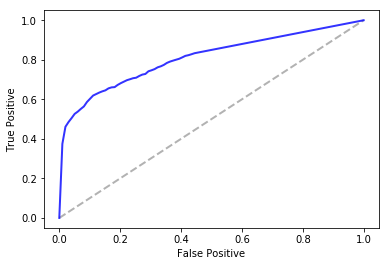

In [27]:
import matplotlib.pyplot as plt
# Line line from origin represnting random predictions
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',alpha=0.3)
#Adding to ROC plot
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'With Augmentation (AUC≈%0.2f $\pm$%0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=0.8)